In [1]:
library(tidyverse)
library(RColorBrewer)
library(cowplot)
library(patchwork)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.0 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




# Microbiome Figure: diversity plots

NMDS plots and alpha diversity plots for all microbiome data layers. All colored by time point.

## Read in data

In [2]:
stool_data = read_csv('../data/metadata/stool/stool_metadata.csv') %>%
                 left_join(read_csv('../data/metadata/stool/stool_abx_usage.csv'), by = 'SampleID') %>%
                 left_join(read_csv('../data/metadata/stool/stool_titers_yr1.csv'), by = 'SampleID') %>%
                 left_join(read_csv('../data/stool/kraken_alpha_diversity.csv'), by = 'SampleID') %>%
                 left_join(read_csv('../data/stool/ko_alpha_diversity.csv'), by = 'SampleID')
stool_kraken_nmds = read_csv('../data/stool/kraken_nmds_babies.csv') %>% rename_with( ~ paste0("Kraken_", .x), -SampleID)
stool_ko_nmds = read_csv('../data/stool/ko_nmds_babies.csv') %>% rename_with( ~ paste0("KO_", .x), -SampleID)
stool_data = stool_data %>% left_join(stool_kraken_nmds, by = 'SampleID') %>% left_join(stool_ko_nmds, by = 'SampleID')
stool_data = stool_data %>% mutate(VR_group = ifelse(is.na(VR_group), 'Not Measured', VR_group))
stool_data = stool_data %>% filter(gt_2.5 == TRUE)
stool_data %>% head

Rows: 709 Columns: 26
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (11): SampleID, SubmissionType, DiversigenCheckInSampleName, BoxLocatio...
dbl   (7): SampleNumber, BabyN, Plate, Row, Column, age_at_collection, Count
lgl   (6): SampleIDValidation, BabyN_checked, DOB_checked, CollectionDate_ch...
date  (2): DOB, CollectionDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 709 Columns: 6
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): SampleID
dbl (2): days_since_abx_start, days_since_abx_end
lgl (3): never_abx, on_abx, previous_abx

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set 

SampleID,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,⋯,species_richness,ko_shannon,ko_evenness,ko_richness,Kraken_MDS1,Kraken_MDS2,Kraken_MDS3,KO_MDS1,KO_MDS2,KO_MDS3
<chr>,<chr>,<dbl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
204_V5,Primary in Tube,1,NA,204_S,"Box 7, A1",Stool,Human Infant,MetaG,204,⋯,262,9.631071,0.06754679,3552,0.04696486,-0.6813761,-0.1710681,0.361944587,-0.2445720,0.13084552
226_V1,Primary in Tube,2,NA,NA,"Box 7, A2",Stool,Human Infant,MetaG,226,⋯,143,11.065302,0.45952748,3481,-1.68264332,-0.2294583,-0.1636196,-0.808974891,-0.1701531,0.05333913
107_V3,Primary in Tube,3,NA,NA,"Box 7, A3",Stool,Human Infant,MetaG,107,⋯,267,10.381667,0.20224759,3664,-0.27366582,-0.8886653,-0.3349565,0.004286036,-0.2128138,-0.38590665
108_V3,Primary in Tube,4,NA,NA,"Box 7, A4",Stool,Human Infant,MetaG,108,⋯,581,10.545280,0.26200950,3485,-0.33309773,0.7469011,0.4898332,-0.054777557,0.5141869,-0.06048777
109_V1,Primary in Tube,5,NA,NA,"Box 7, A5",Stool,Human Infant,MetaG,109,⋯,193,9.624191,0.11626061,2458,-0.80339905,-0.6660686,-0.5369415,0.367008649,-0.2352781,0.17121560
108_V2,Primary in Tube,6,NA,NA,"Box 7, A6",Stool,Human Infant,MetaG,108,⋯,178,9.220455,0.10696066,2822,-0.99773114,1.0968788,0.3873633,0.193437912,0.7153323,0.55921270


In [3]:
nasal_data = read_csv('../data/metadata/nasal/nasal_metadata.csv')
nasal_data = nasal_data %>%
                 add_column('age_at_collection' = as.double(difftime(nasal_data$CollectionDate, nasal_data$DOB, units='days'))) %>%
                 left_join(read_csv('../data/metadata/nasal/nasal_abx_usage.csv'), by='SampleID') %>%
                 left_join(read_csv('../data/metadata/nasal/nasal_titers_yr1.csv'), by='SampleID') %>%
                 left_join(read_csv('../data/nasal/otu_alpha_diversity.csv'), by = 'SampleID') %>%
                 left_join(read_csv('../data/nasal/otu_nmds_babies.csv'))
head(nasal_data)

Rows: 1008 Columns: 23
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (10): SubmissionType, SampleID, DiversigenCheckInSampleName, ReplacesLo...
dbl   (6): SampleNumber, SequencingType, BabyN, Plate, Row, Column
lgl   (5): SampleIDValidation, BabyN_checked, DOB_checked, CollectionDate_ch...
date  (2): DOB, CollectionDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1008 Columns: 6
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): SampleID
dbl (2): days_since_abx_start, days_since_abx_end
lgl (3): never_abx, on_abx, previous_abx

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_co

SubmissionType,SampleNumber,SampleID,SampleIDValidation,DiversigenCheckInSampleName,ReplacesLowVolumeSampleID,BoxLocation,SampleType,SampleSource,SequencingType,⋯,protectNorm_PRN,protectNorm_FHA,geommean_protectNorm,VR_group_v2,shannon_div,simpson_e_div,n_otus_div,MDS1,MDS2,MDS3
<chr>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Primary in Tube,1,103_V5_NS_A1,NA,NA,NA,"Box 1, A1",Nasal Swab,Human Infant,16,⋯,NA,NA,NA,NA,1.72045185,0.07548099,38,0.03476964,0.2711453,-0.24546932
Primary in Tube,2,106_V5_NS_A1,NA,NA,NA,"Box 1, A3",Nasal Swab,Human Infant,16,⋯,0.3125,1.3750,1.1403884,NVR,1.25565101,0.07274257,22,-0.34349902,0.1522628,0.44060459
Primary in Tube,3,107_V2_NS_A1,NA,NA,NA,"Box 1, A4",Nasal Swab,Human Infant,16,⋯,1.1250,0.3750,1.7834178,NVR,NA,NA,NA,NA,NA,NA
Primary in Tube,4,107_V3_NS_A1,NA,107_V8_NS_A1,NA,"Box 1, A5",Nasal Swab,Human Infant,16,⋯,1.1250,0.3750,1.7834178,NVR,NA,NA,NA,NA,NA,NA
Primary in Tube,5,107_V5_NS_A1,NA,NA,NA,"Box 1, A8",Nasal Swab,Human Infant,16,⋯,1.1250,0.3750,1.7834178,NVR,1.69497733,0.16593460,17,-0.36385022,0.2648479,-0.07368183
Primary in Tube,6,108_V4_NS_A1,NA,NA,NA,"Box 1, A9",Nasal Swab,Human Infant,16,⋯,0.3125,0.1875,0.4494199,LVR,0.05357943,0.07763519,13,-0.50225697,0.3444246,-0.10050053


## NMDS across time

### Stool Kraken

Saving 7 x 7 in image


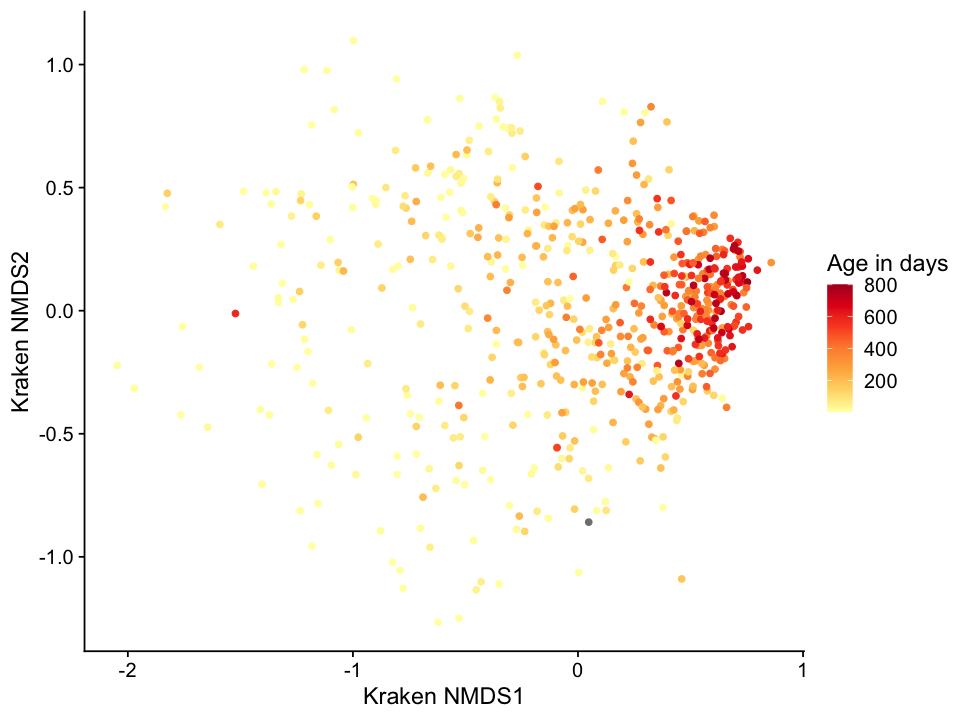

In [4]:
options(repr.plot.width=8, repr.plot.height=6)
stool_data %>% ggplot(aes(x=Kraken_MDS1, y=Kraken_MDS2, color=age_at_collection)) +
                      geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1) +
                      theme_cowplot() + labs(x = "Kraken NMDS1", y = "Kraken NMDS2", color = "Age in days")
ggsave('../figures/kraken_nmds_w_age.pdf', dpi=300)

### Stool KOs

Saving 7 x 7 in image


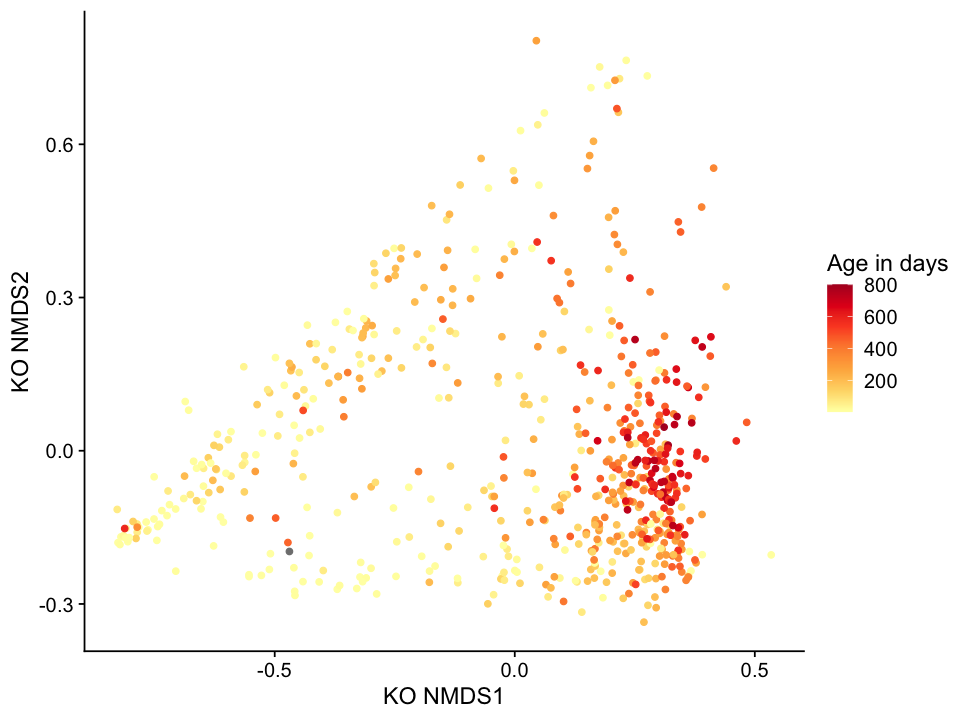

In [5]:
options(repr.plot.width=8, repr.plot.height=6)
stool_data %>% ggplot(aes(x=KO_MDS1, y=KO_MDS2, color=age_at_collection)) +
                   geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)  +
                   theme_cowplot() + labs(x = "KO NMDS1", y = "KO NMDS2", color = "Age in days")
ggsave('../figures/ko_nmds_w_age.pdf', dpi=300)

### Nasal 16S

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”
Saving 7 x 7 in image
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


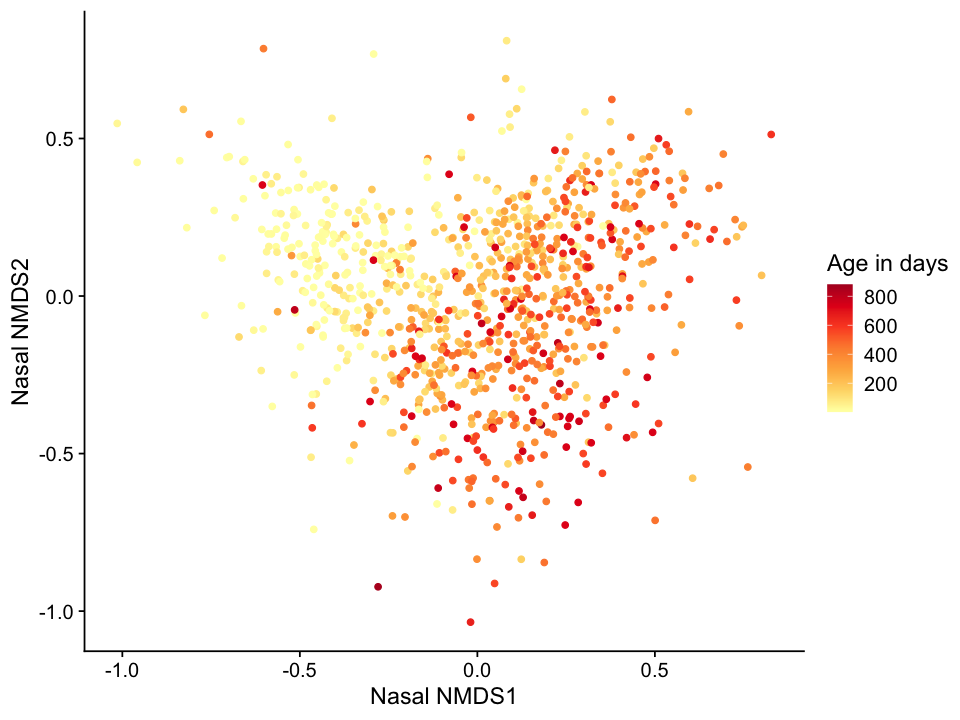

In [6]:
options(repr.plot.width=8, repr.plot.height=6)
nasal_data %>% ggplot(aes(x=MDS1, y=MDS2, color=age_at_collection)) +
                   geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)  +
                   theme_cowplot() + labs(x = "Nasal NMDS1", y = "Nasal NMDS2", color = "Age in days")
ggsave('../figures/otu_nmds_w_age.pdf', dpi=300)

## Alpha diversity across time

### Stool Kraken

Saving 7 x 7 in image


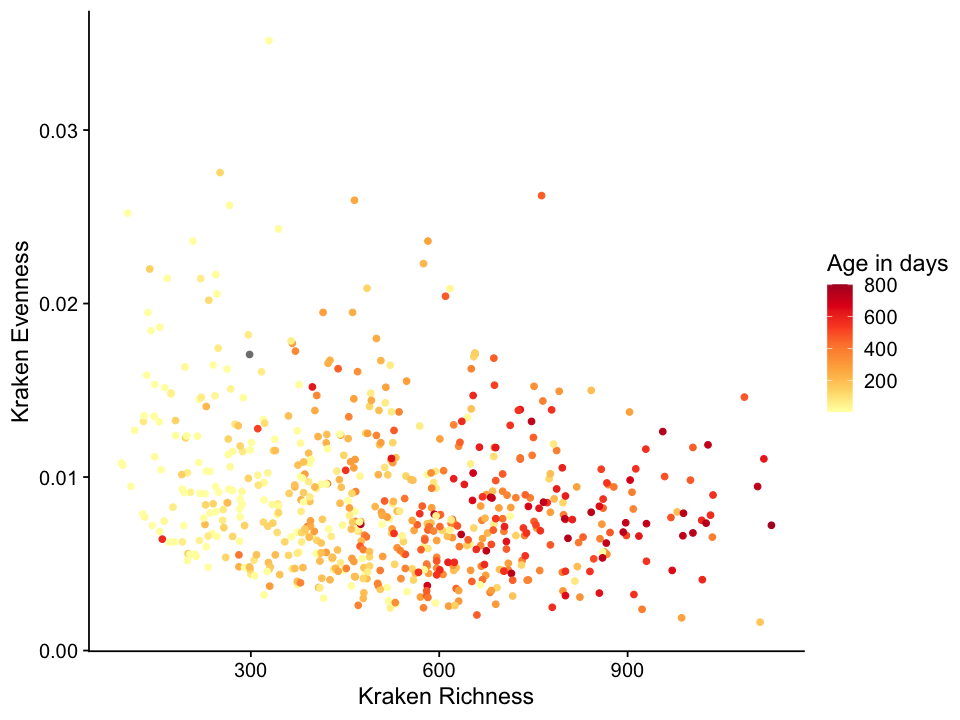

In [7]:
options(repr.plot.width=8, repr.plot.height=6)
stool_data %>% ggplot(aes(x=species_richness, y=species_evenness, color=age_at_collection)) +
                   geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)  +
                   theme_cowplot() + labs(x = "Kraken Richness", y = "Kraken Evenness", color = "Age in days")
ggsave('../figures/kraken_alphadiv_w_age.pdf', dpi=300)

### Stool KOs

Saving 7 x 7 in image


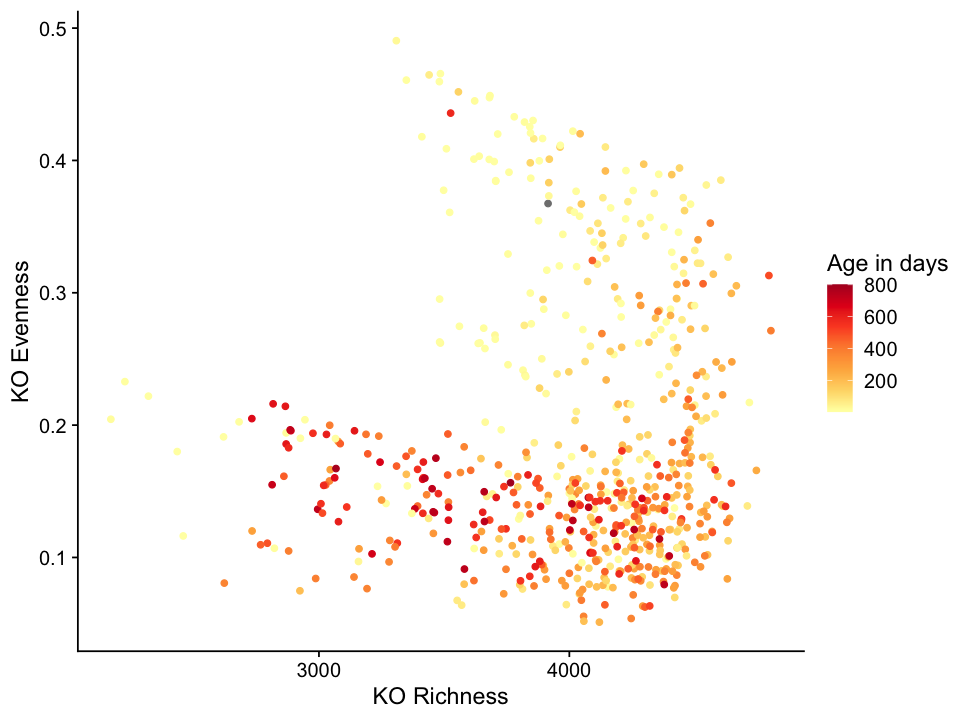

In [8]:
options(repr.plot.width=8, repr.plot.height=6)
stool_data %>% ggplot(aes(x=ko_richness, y=ko_evenness, color=age_at_collection)) +
                   geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)  +
                   theme_cowplot() + labs(x = "KO Richness", y = "KO Evenness", color = "Age in days")
ggsave('../figures/ko_alphadiv_w_age.pdf', dpi=300)

### Nasal 16S

Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”
Saving 7 x 7 in image
Warning message:
“Removed 64 rows containing missing values (`geom_point()`).”


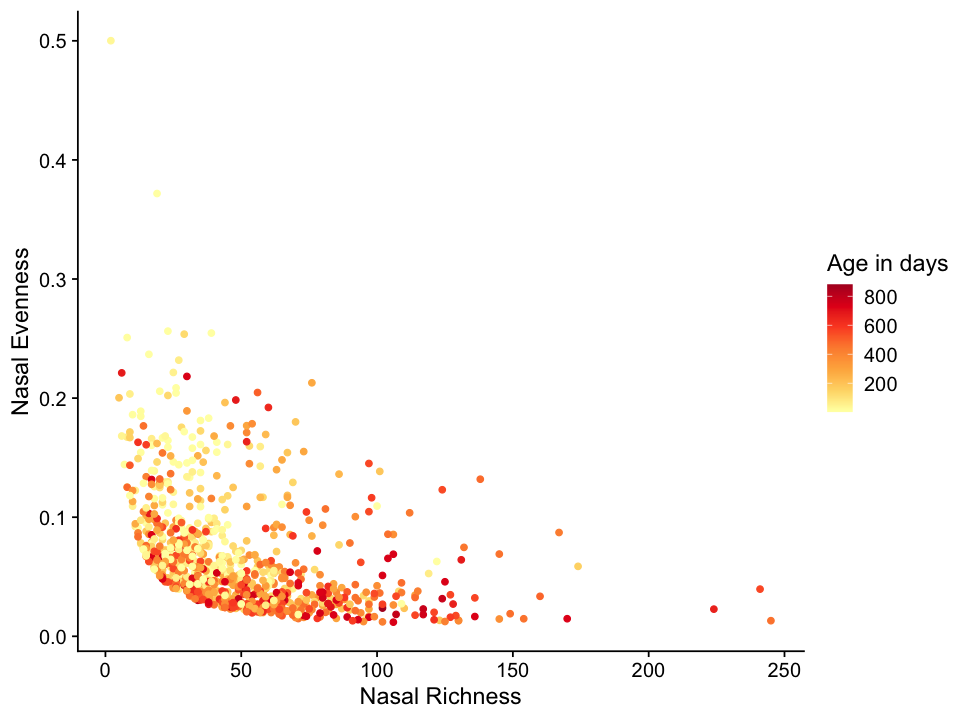

In [9]:
options(repr.plot.width=8, repr.plot.height=6)
nasal_data %>% ggplot(aes(x=n_otus_div, y=simpson_e_div, color=age_at_collection)) +
                   geom_point() + scale_color_distiller(palette = 'YlOrRd', direction = 1)  +
                   theme_cowplot() + labs(x = "Nasal Richness", y = "Nasal Evenness", color = "Age in days")
ggsave('../figures/otu_alphadiv_w_age.pdf', dpi=300)